Notebook to collect the information of the generation

### Import

In [1]:
import sys, os, re, yaml, pickle
import commands
from glob import glob
from prettytable import PrettyTable
sys.path.append('../lib')

import time, datetime

In [2]:
import signal

class TimeoutError(Exception):
    pass

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

# with timeout(seconds=1):
#     try:
#         time.sleep(2)
#     except TimeoutError:
#         print 'Got it'

In [3]:
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from progressBar import ProgressBar

In [4]:
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

Welcome to JupyROOT 6.12/07


In [5]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Lumis
from DataFormats.FWLite import Handle
# import commands

In [6]:
from analysis_utilities import DSetLoader

# Inputs

Max 3 dataset per time otherwise run out of memory

In [7]:
# order = ['mu_c0', 'tau_c0',
#          'DstPip_c0', 'DstPi0_c0', 'DststPipPi0_c0', 'DststPipPim_c0', 'DststPi0Pi0_c0', 
#          'Bp_TauNuDstst_Pip_PUc0', 'B0_TauNuDstst_Pi0_PUc0',
#          'DstmDsp','DstmD0','DstmDp','BpHc','BmHc','antiB0Hc',
#         ]

In [8]:
inDic = {}

In [9]:
######## Signals
# inDic['Bd_MuNuDst'] = DSetLoader('Bd_MuNuDst', candDir='ntuples_B2DstMu_220201')
# inDic['Bd_TauNuDst'] = DSetLoader('Bd_TauNuDst', candDir='ntuples_B2DstMu_220201')
######## D** background
inDic['Bu_MuDstPi'] = DSetLoader('Bu_MuNuDstPi', candDir='ntuples_B2DstMu_220201')
inDic['Bd_MuDstPi'] = DSetLoader('Bd_MuNuDstPi', candDir='ntuples_B2DstMu_220201')
# inDic['Bd_MuDstPiPi'] = DSetLoader('Bd_MuNuDstPiPi', candDir='ntuples_B2DstMu_mediumId')
inDic['Bu_MuDstPiPi'] = DSetLoader('Bu_MuNuDstPiPi', candDir='ntuples_B2DstMu_220201')
inDic['Bu_MuDstPiPi_v3'] = DSetLoader('Bu_MuNuDstPiPi_v3', candDir='ntuples_B2DstMu_220201')
inDic['Bd_MuDstPiPi_v2'] = DSetLoader('Bd_MuNuDstPiPi_v2', candDir='ntuples_B2DstMu_220201')
inDic['Bd_MuDstPiPi_v3'] = DSetLoader('Bd_MuNuDstPiPi_v3', candDir='ntuples_B2DstMu_220201')
inDic['Bu_TauDstPi'] = DSetLoader('Bu_TauNuDstPi', candDir='ntuples_B2DstMu_220201')
inDic['Bd_TauDstPi'] = DSetLoader('Bd_TauNuDstPi', candDir='ntuples_B2DstMu_220201')
inDic['Bd_TauDstPiPi'] = DSetLoader('Bd_TauNuDstPiPi', candDir='ntuples_B2DstMu_220201')
inDic['Bu_TauDstPiPi'] = DSetLoader('Bu_TauNuDstPiPi', candDir='ntuples_B2DstMu_220201')
inDic['Bs_MuDstK'] = DSetLoader('Bs_MuNuDstK', candDir='ntuples_B2DstMu_220201')
inDic['Bs_TauDstK'] = DSetLoader('Bs_TauNuDstK', candDir='ntuples_B2DstMu_220201')

######## D*Hc background
# inDic['Bd_DstDu'] = DSetLoader('Bd_DstDu', candDir='ntuples_B2DstMu_220201')
# inDic['Bd_DstDd'] = DSetLoader('Bd_DstDd', candDir='ntuples_B2DstMu_220201')
# inDic['Bd_DstDs'] = DSetLoader('Bd_DstDs', candDir='ntuples_B2DstMu_220201')
# inDic['Bu_DstDu'] = DSetLoader('Bu_DstDu', candDir='ntuples_B2DstMu_220201')
# inDic['Bu_DstDd'] = DSetLoader('Bu_DstDd', candDir='ntuples_B2DstMu_220201')
# inDic['Bs_DstDs'] = DSetLoader('Bs_DstDs', candDir='ntuples_B2DstMu_220201')

######## Others background
# inDic['DstKu_KuToMu'] = DSetLoader('DstKu_KuToMu', candDir='ntuples_B2DstMu_211118')

CAND efficiency file missing for Bu_MuNuDstPiPi.
CAND efficiency file missing for Bu_MuNuDstPiPi_v3.
CAND efficiency file missing for Bd_MuNuDstPiPi_v2.
CAND efficiency file missing for Bd_MuNuDstPiPi_v3.
CAND efficiency file missing for Bd_TauNuDstPiPi.
CAND efficiency file missing for Bu_TauNuDstPiPi.


In [10]:
# inDic['JPsiKst'] = DSetLoader('Bd_JpsiKst_General', candDir='ntuples_B2JpsiKst')

In [11]:
# inDic['muHQET_0'] = DSetLoader('B0_MuNuDmst_HQETcentral_PU0')
# inDic['mu_0'] = DSetLoader('B0_MuNuDmst_PU0')
# inDic['mu_20'] = DSetLoader('B0_MuNuDmst_PU20')
# inDic['mu_c0'] = DSetLoader('B0_MuNuDmst_PUc0')
# inDic['muSoft_c0'] = DSetLoader('B0_MuNuDmst_SoftQCDall_PUc0')
# inDic['mu_35'] = DSetLoader('B0_MuNuDmst_PU35')

# inDic['tau_0'] = DSetLoader('B0_TauNuDmst_PU0')
# inDic['tau_20'] = DSetLoader('B0_TauNuDmst_PU20')
# inDic['tau_c0'] = DSetLoader('B0_TauNuDmst_PUc0')
# inDic['tau_35'] = DSetLoader('B0_TauNuDmst_PU35')

# inDic['Hc_20'] = DSetLoader('B0_DmstHc_PU20')
# inDic['Hc_c0'] = DSetLoader('B0_DmstHc_PUc0')


# inDic['DstmDsp'] = DSetLoader('B0_DstmDsp_PUc0')

# inDic['DstmDp'] = DSetLoader('B0_DstmDp_PUc0')

# inDic['DstmD0'] = DSetLoader('B0_DstmD0_PUc0')

# inDic['BpHc'] = DSetLoader('Bp_DstmHc_PUc0')

# inDic['BmHc'] = DSetLoader('Bm_DstmHc_PUc0')

# inDic['antiB0Hc'] = DSetLoader('antiB0_DstmHc_PUc0')


# inDic['DstPip_20'] = DSetLoader('Bp_MuNuDstst_PU20')
# inDic['DstPip_c0'] = DSetLoader('Bp_MuNuDstst_Pip_PUc0')

# inDic['DstPi0_c0'] = DSetLoader('B0_MuNuDstst_Pi0_PUc0')

# inDic['DstPi0_nR_c0'] = DSetLoader('B0_DmstPi0MuNu_PUc0')

# inDic['DststPipPi0_c0'] = DSetLoader('Bp_MuNuDstst_PipPi0_PUc0')
# inDic['DststPipPi0_nR_c0'] = DSetLoader('Bp_MuNuDstPipPi0_PUc0')

# inDic['DststPipPim_c0'] = DSetLoader('B0_MuNuDstst_PipPim_PUc0')
# inDic['DststPipPim_nR_c0'] = DSetLoader('B0_MuNuDstPipPim_PUc0')

# inDic['DststPi0Pi0_c0'] = DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0')

# inDic['B0_DststPiPiPi_c0'] = DSetLoader('B0_MuNuDstPiPiPi_PUc0')

# inDic['Bp_DststPiPiPi_c0'] = DSetLoader('Bp_MuNuDstPiPiPi_PUc0')

# inDic['B0_TauNuDstst_Pi0_PUc0'] = DSetLoader('B0_TauNuDstst_Pi0_PUc0')

# inDic['Bp_TauNuDstst_Pip_PUc0'] = DSetLoader('Bp_TauNuDstst_Pip_PUc0')

In [12]:
# inDic['mu_0'] = DSetLoader('B0_MuNuDmst_PU0', candDir='ntuples_probeB2DstMu')
# inDic['p_mu_c0'] = DSetLoader('p_B0_MuNuDst_PUc0', candDir='ntuples_probeB2DstMu')
# inDic['p_tau_c0'] = DSetLoader('p_B0_TauNuDst_PUc0', candDir='ntuples_probeB2DstMu')

In [13]:
# inDic['JPsiKst_0'] = DSetLoader('B0_JpsiKst_PU0', candDir='ntuples_B2JpsiKst')
# inDic['JPsiKst_20'] = DSetLoader('B0_JpsiKst_PU20', candDir='ntuples_B2JpsiKst')
# inDic['JPsiKst_35'] = DSetLoader('B0_JpsiKst_PU35', candDir='ntuples_B2JpsiKst')

# inDic['JPsiKstFSR_20'] = DSetLoader('B0_JpsiKstFSR_PU20', candDir='ntuples_B2JpsiKst')
# inDic['JPsiKst_c0'] = DSetLoader('B0_JpsiKst_PUc0', candDir='ntuples_B2JpsiKst')
# inDic['JPsiKst_c0'] = DSetLoader('B0_JpsiX_SoftQCD_PU20', candDir='ntuples_B2JpsiKst')

# inDic['JPsiK_c0'] = DSetLoader('Bp_JpsiK_PUc0', candDir='ntuples_B2JpsiK')

# Efficiency

In [14]:
def getEff(k,N):
    e = k/float(N)
    de = np.sqrt(e*(1-e)/N)
    return [e, de]

## Generator Efficiency

In [15]:
handle = {}
handle['genFilter'] = [Handle('GenFilterInfo'), ('genFilterEfficiencyProducer', '', 'SIM')]
handle['genProduct'] = [Handle('GenLumiInfoProduct'), ('generator', '', 'SIM')]

In [16]:
def analyzeMINIAODs(fileList):  
    print 'Analizing', len(fileList), 'MINIAOD'
    N_gen = 0
    N_cuts = 0
    xsec = []
    xsec_err = []
    pb = ProgressBar(maxEntry=len(fileList))
    skippedFiles = []
    for i_j, fileName in enumerate(fileList):
        if not os.path.exists(fileName):
            fileName = 'root://cmsxrootd.fnal.gov/' + fileName
        pb.show(i_j)
        with timeout(seconds=30):
            try:
#                 cmd = 'python generatorEfficiency_MINIAODSIM.py ' + fileName
#                 status, output = commands.getstatusoutput(cmd)
#                 aux = output.split(' ')
#                 N_gen += float(aux[0])
#                 N_cuts += float(aux[1])
#                 xsec.append(float(aux[2]))
#                 xsec_err.append(float(aux[4]))
                for lumi in Lumis(fileName):
                    prods = {}
                    for k,v in handle.iteritems():
                        lumi.getByLabel(v[1], v[0])
                        prods[k] = v[0].product()
                    N_cuts += prods['genFilter'].numEventsPassed()
                    N_gen += prods['genFilter'].numEventsTotal()
                    xs = prods['genProduct'].getProcessInfos()[0].lheXSec()
                    xsec.append(xs.value())
                    xsec_err.append(xs.error())
            except TimeoutError:
                skippedFiles.append(fileName)
    print 'Skipped {} files'.format(len(skippedFiles))
    print 'Total events in analyzed MINIAODs', N_cuts
    xsec = np.array(xsec)
    xsec_err = np.array(xsec_err)
    return N_gen, N_cuts, xsec, xsec_err

In [17]:
N_max = 200
recreate = []
# recreate = inDic.keys()
for n, d in inDic.iteritems():
    print '\n\n--> ' + d.sample
    
    outdir = os.path.join(d.candLoc, d.full_name)
    outyamlFile = os.path.join(outdir,'effMCgenerator.yaml')
    if os.path.isfile(outyamlFile) and not n in recreate:
        print 'Already present'
        dic = yaml.load(open(outyamlFile, 'r'))
        print dic
        continue
        
    fileList = d.MINIAOD_filelist
    if N_max > 0 and N_max < len(fileList):
        fileList = np.random.choice(fileList, N_max)
    elif len(fileList) == 0:
        print 'No MiniAODs found, skipping'
        continue
    
    N_gen, N_cuts, xsec, xsec_err = analyzeMINIAODs(fileList)
    s2 = np.square(xsec_err)
    num = np.sum(xsec/s2)
    den = np.sum(1./s2)
    xsecAvg = 1e3*num/den
    xsecAvg_err = 1e3*np.sqrt(1/den)
    chi2 = np.sum(np.square((xsec - xsecAvg*1e-3)/xsec_err))
    pval = rt.ROOT.Math.chisquared_cdf_c(chi2, len(xsec)-1)
    print 'Chi2: {:.1f}/{} ({:.1f}%)'.format(chi2, len(xsec)-1, pval*100)
    print 'Xsec: {:1.4e} +/- {:1.4e} fb ({:1.1e})'.format(xsecAvg, xsecAvg_err, xsecAvg_err/xsecAvg)
    d.xsec = [xsecAvg, xsecAvg_err]
    
    e, de = getEff(N_cuts, N_gen)
    print 'eff generator: {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    d.effGEN = [e, de]

    dump_dic = {}
    for k in ['xsec', 'effGEN']:
        aux = getattr(d, k)
        dump_dic[k] = [float(aux[0]), float(aux[1])]
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    with open(outyamlFile, 'w') as dumpF:
        dumpF.write(yaml.dump(dump_dic, default_flow_style=False, default_style=''))



--> Bs_TauNuDstK
Already present
{'xsec': [456677828218.53046, 36048904.2320488], 'effGEN': [0.0005487288964862666, 1.8562417474426523e-06]}


--> Bd_TauNuDstPi
Already present
{'xsec': [456627934865.00574, 33695681.406900726], 'effGEN': [0.0019594178212750325, 3.2767437737953146e-06]}


--> Bu_MuNuDstPiPi
Already present
{'xsec': [456764703863.9451, 143935893.4645797], 'effGEN': [0.006834248497993219, 2.606902892286946e-05]}


--> Bs_MuNuDstK
Already present
{'xsec': [456726488997.22565, 36573692.07147653], 'effGEN': [0.0023048419118000766, 3.855897991944063e-06]}


--> Bd_MuNuDstPi
Already present
{'xsec': [456744006710.3446, 66325418.73642332], 'effGEN': [0.00757017976646805, 1.2638682968523077e-05]}


--> Bd_MuNuDstPiPi_v2
Already present
{'xsec': [456751743865.18774, 83151447.18339601], 'effGEN': [0.00607683952214688, 1.4206841009607407e-05]}


--> Bd_MuNuDstPiPi_v3
Already present
{'xsec': [456575472892.70526, 83212782.27491288], 'effGEN': [0.005156072937918303, 1.3107102093328

## ntuplizer efficiency

In [18]:
for d in inDic.values():
    print '\n\n--> ' + d.sample

    if not os.path.isdir(d.ntuples_dir):
        continue
    cand_out_list = glob(os.path.join(d.ntuples_dir,'out/job*.out'))
#     if d.sample == 'Bd_MuNuDst':
#         cand_out_list = glob(os.path.join(d.ntuples_dir,'out/job_???_*.out'))
    N_analyzed = 0
    N_trg = 0
    N_cand = 0
    print 'Analyzing {} ntuplizer job logs'.format(len(cand_out_list))
    pb = ProgressBar(maxEntry=len(cand_out_list))
    for ic, cand_out in enumerate(cand_out_list):
        pb.show(ic)
        eff_ln = []
        counters = []
        takingCounters = False
        for line in open(cand_out).readlines():
            if 'efficiency:' in line:
                eff_ln.append(line)
            elif 'counters:' in line:
                    takingCounters = True
            elif takingCounters and line[:-1].isdigit():
                counters.append(int(line[:-1]))
            elif takingCounters:
                takingCounters = False
#             print line
        aux = re.search('[0-9]+/[0-9]+', eff_ln[0]).group(0)
        aux = aux.split('/')
        N_analyzed += int(aux[1])
        N_trg += int(aux[0])
        
        aux = re.search(': [0-9]+/', eff_ln[1]).group(0)
        N_cand += int(aux[2:-1])
        
        counters=np.array(counters)
        if not hasattr(d, 'counters'):
            d.counters = counters
        else:
            d.counters += counters
        
    d.nTotMINIAOD = N_analyzed
    d.nTotCAND = N_cand
    print 'Total MINIAOD:', N_analyzed
    print 'Total candidates:', N_cand
    
    e, de = getEff(N_trg, N_analyzed)
    d.effCAND_trg = e, de
    print 'eff candidates (trigger): {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    latexStr = '${:.2f} \pm {:.2f}$'.format(100*e, 100*de)
    
    e, de = getEff(N_cand, N_trg)
    d.effCAND_cand = e, de
    print 'eff candidates (cand): {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    latexStr += ' & ${:.2f} \pm {:.2f}$'.format(100*e, 100*de)
    
    
    e, de = getEff(N_cand, N_analyzed)
    d.effCAND = e, de
    print 'eff candidates: {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    latexStr += ' & ${:.2f} \pm {:.2f}$\\'.format(100*e, 100*de)
    print latexStr
    
    print 'Getting the total rates (if existing)'
    try:
        fCandLoc = glob(os.path.join(d.ntuples_dir,'out_CAND_*.root'))[0]
        fCand = ur.open(fCandLoc)
        Trate = fCand['p']['Trate']
        d.rate = {}
        for k in Trate.keys():
            r = Trate.array(k)[0]
            r *= 1e12 #GeV -> meV
            d.rate[str(k)] = r
        print 'Done'
    except:
        print 'Not found'
    
    dump_dic = {'nTotMINIAOD': int(d.nTotMINIAOD), 'nTotCAND': int(d.nTotCAND)}
    for k in ['effCAND', 'effCAND_trg', 'effCAND_cand']:
        aux = getattr(d, k)
        dump_dic[k] = [float(aux[0]), float(aux[1])]
    if hasattr(d, 'rate'):
        for k, v in d.rate.iteritems():
            dump_dic['rate_'+k] = float(v)
    with open(os.path.join(d.ntuples_dir,'effCAND.yaml'), 'w') as dumpF:
        dumpF.write(yaml.dump(dump_dic, default_flow_style=False, default_style=''))



--> Bs_TauNuDstK
Analyzing 9 ntuplizer job logs
[#########]  100% - Tot. time: 0.2 s
Total MINIAOD: 905667
Total candidates: 37432
eff candidates (trigger): 4.092e-01 +/- 5.167e-04 (1.3e-03)
eff candidates (cand): 1.010e-01 +/- 4.950e-04 (4.9e-03)
eff candidates: 4.133e-02 +/- 2.092e-04 (5.1e-03)
$40.92 \pm 0.05$ & $10.10 \pm 0.05$ & $4.13 \pm 0.02$\
Getting the total rates (if existing)
Not found


--> Bd_TauNuDstPi
Analyzing 10 ntuplizer job logs
[##########]  100% - Tot. time: 0.3 s
Total MINIAOD: 959226
Total candidates: 48189
eff candidates (trigger): 4.135e-01 +/- 5.028e-04 (1.2e-03)
eff candidates (cand): 1.215e-01 +/- 5.188e-04 (4.3e-03)
eff candidates: 5.024e-02 +/- 2.230e-04 (4.4e-03)
$41.35 \pm 0.05$ & $12.15 \pm 0.05$ & $5.02 \pm 0.02$\
Getting the total rates (if existing)
Not found


--> Bu_MuNuDstPiPi
Analyzing 130 ntuplizer job logs
[####################]  100% - Tot. time: 1.7 s
Total MINIAOD: 6544720
Total candidates: 269924
eff candidates (trigger): 3.853e-01 +/- 1

+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+
|      Sample     |   0   |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |  10  |  11  |  12  |
+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+
|    Bs_TauDstK   | 40.92 | 40.41 | 39.67 | 37.68 | 36.08 | 30.26 | 18.79 | 18.75 | 17.10 |  9.73 | 4.45 | 4.13 | 4.13 |
|   Bd_TauDstPi   | 41.35 | 40.84 | 40.07 | 38.24 | 36.69 | 31.15 | 20.71 | 20.68 | 18.72 | 10.89 | 5.40 | 5.02 | 5.02 |
|   Bu_MuDstPiPi  | 38.53 | 38.00 | 37.43 | 36.13 | 34.42 | 29.49 | 17.93 | 17.90 | 16.11 |  8.94 | 4.18 | 4.12 | 4.12 |
|    Bs_MuDstK    | 36.99 | 36.47 | 35.96 | 34.19 | 32.60 | 26.84 | 17.05 | 17.02 | 15.37 |  8.33 | 3.80 | 3.76 | 3.76 |
|    Bd_MuDstPi   | 37.54 | 37.01 | 36.49 | 34.53 | 32.83 | 27.01 | 17.05 | 17.02 | 15.26 |  8.46 | 4.17 | 4.12 | 4.12 |
| Bd_MuDstPiPi_v2 | 37.24 | 36.7

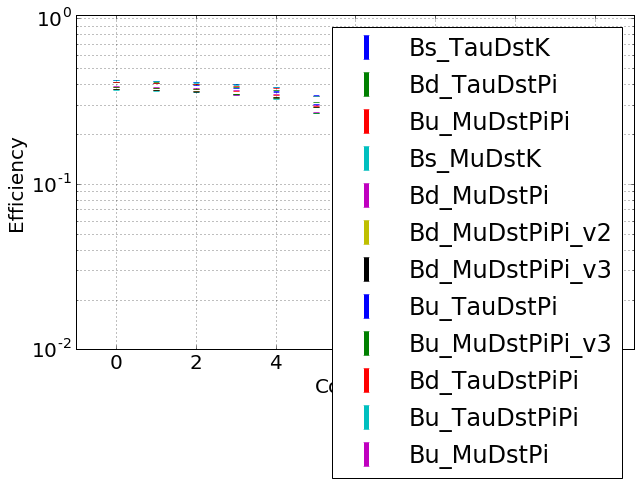

In [19]:
t = PrettyTable()
t.field_names = ['Sample'] + [str(i) for i in range(d.counters.shape[0])]
for n, d in inDic.iteritems():
    eff = np.zeros((d.counters.shape[0], 2))
    eff[0] = d.effCAND_trg
    for i in range(d.counters[1:].shape[0]):
        eff[i+1] = getEff(d.counters[i+1], d.nTotMINIAOD)
    t.add_row([n] + ['{:.2f}'.format(100*e[0]) for e in eff])
    x = np.arange(eff.shape[0])
    p = plt.errorbar(x, eff[:, 0], eff[:,1], lw=0, elinewidth=5, label=n)
    
#     plt.plot(x[[0,-1]], 2*[d.effCAND[0]], '-', color=p[0].get_color())
#     plt.fill_between(x[[0,-1]], 2*[d.effCAND[0]-d.effCAND[1]], 2*[d.effCAND[0]+d.effCAND[1]], color=p[0].get_color(), alpha=0.2)
print t
plt.rcParams.update({'font.size': 20})
plt.xlabel('Counter')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.ylim(0.01,1.05)
plt.xlim(-1, eff.shape[0])
plt.grid(True, which='both')
plt.yscale('log')
plt.gcf().set_size_inches(10, 6)

+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+
|      Sample     |   0   |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |   10  |   11  |   12   |
+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+
|    Bs_TauDstK   | 40.92 | 98.75 | 98.16 | 94.98 | 95.77 | 83.88 | 62.08 | 99.81 | 91.22 | 56.87 | 45.71 | 92.96 | 99.99  |
|   Bd_TauDstPi   | 41.35 | 98.77 | 98.11 | 95.45 | 95.95 | 84.88 | 66.50 | 99.83 | 90.51 | 58.16 | 49.59 | 93.08 | 99.99  |
|   Bu_MuDstPiPi  | 38.53 | 98.61 | 98.50 | 96.54 | 95.26 | 85.68 | 60.79 | 99.81 | 90.01 | 55.48 | 46.75 | 98.73 | 100.00 |
|    Bs_MuDstK    | 36.99 | 98.59 | 98.60 | 95.09 | 95.33 | 82.34 | 63.52 | 99.84 | 90.28 | 54.22 | 45.65 | 98.85 | 99.99  |
|    Bd_MuDstPi   | 37.54 | 98.60 | 98.58 | 94.64 | 95.09 | 82.26 | 63.14 | 99.82 | 89.66 | 55.45 | 49.22 | 98.85 | 99.99  |


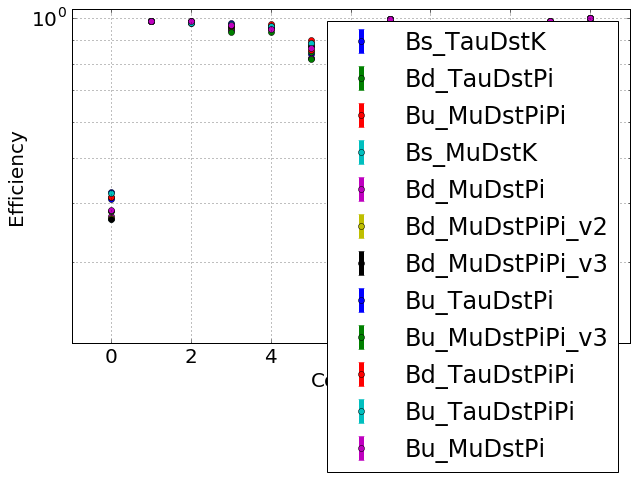

In [20]:
t = PrettyTable()
t.field_names = ['Sample'] + [str(i) for i in range(d.counters.shape[0])]
for n, d in inDic.iteritems():
    eff = np.zeros((d.counters.shape[0], 2))
    eff[0] = d.effCAND_trg
    for i in range(d.counters[1:].shape[0]):
        eff[i+1] = getEff(d.counters[i+1], d.counters[i])
    t.add_row([n] + ['{:.2f}'.format(100*e[0]) for e in eff])
    x = np.arange(eff.shape[0])
    p = plt.errorbar(x, eff[:, 0], eff[:,1], fmt='o', lw=0, elinewidth=5, label=n)
print t
plt.rcParams.update({'font.size': 20})
plt.xlabel('Counter')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.ylim(0.2,1.05)
plt.xlim(-1, eff.shape[0])
plt.grid(True, which='both')
plt.yscale('log')
plt.gcf().set_size_inches(10, 6)

## Skim Efficiency

In [21]:
for p in order:
    if not p in inDic.keys():
        continue
    
    s = []
    for c in ['Low', 'Mid', 'High']:
        s.append(inDic[p].printSkimEffLatex(c+'_bare'))
    s = ' & '.join(s)
    s += '\\\\'
#     print p, s
    print s

NameError: name 'order' is not defined

# Comparison table

In [ ]:
# Latex format

latexTable = r'''
\begin{tabular}{|c||c|c||cc|c||cc|cc|cc|}
 \hline
 Process & 
 xsec [b] & $\varepsilon_\text{gen}$ & 
 $\varepsilon_\text{trg}$ [\%]& $\varepsilon_\text{cand}$ [\%]& 
 $\varepsilon_\text{ntp} = \varepsilon_\text{trg}\varepsilon_\text{cand}$ [\%] &
 $\varepsilon_\text{skim}^{low}$ [\%] & $\varepsilon_\text{ntp}\varepsilon_\text{skim}^{low}$ [\%] &
 $\varepsilon_\text{skim}^{mid}$ [\%] & $\varepsilon_\text{ntp}\varepsilon_\text{skim}^{mid}$ [\%] &
 $\varepsilon_\text{skim}^{high}$ [\%] & $\varepsilon_\text{ntp}\varepsilon_\text{skim}^{high}$ [\%] &
 \\
 \hline
 \hline
'''

procTraslation = {
    'mu_c0': r'$B\to D^*\mu\nu$ (hard $b\bar{b}$)',
    'muSoft_c0': r'$B\to D^*\mu\nu$ (soft QCD all)',
}

for n, ds in inDic.iteritems():
    name = procTraslation[n] if n in procTraslation.keys() else n
    fields = [name]
    xsec = '{:.3f}'.format(1e-12*ds.effMCgen['xsec'][0])   
    eGen = '{:1.2e}'.format(ds.effMCgen['effGEN'][0])
    fields += [xsec, eGen]
    for k in ['effCAND_trg', 'effCAND_cand', 'effCAND']:
        s = '{:.2f}'.format(100*ds.effCand[k][0])
        fields.append(s)
    for k in ['Low', 'Mid', 'High']:
        s = '{:.2f}'.format(100*ds.getSkimEff(k+'_bare')[0])
        fields.append(s)
    latexTable += ' ' + ' & '.join(fields) + ' \\\\\n \hline\n'
latexTable += r'\end{tabular}' + '\n'
print latexTable

In [ ]:
# Latex format transposed

latexTable = r'\begin{tabular}{|'+len(inDic.keys() + ['a'])*r'c|'+r'}\n\hline\n'

fieldNames = [
    r'Process',
    r'xsec [b]',
    r'$\varepsilon_\text{gen}$',
    r'$\varepsilon_\text{trg}$ [\%]',
    r'$\varepsilon_\text{cand}$ [\%]',
    r'$\varepsilon_\text{ntp} = \varepsilon_\text{trg}\varepsilon_\text{cand}$ [\%]',
    r'$\varepsilon_\text{skim}^{low}$ [\%]',
    r'$\varepsilon_\text{ntp}\varepsilon_\text{skim}^{low}$ [\%]',
    r'$\varepsilon_\text{skim}^{mid}$ [\%]',
    r'$\varepsilon_\text{ntp}\varepsilon_\text{skim}^{mid}$ [\%]',
    r'$\varepsilon_\text{skim}^{high}$ [\%]',
    r'$\varepsilon_\text{ntp}\varepsilon_\text{skim}^{high}$ [\%]'
]

procTraslation = {
    'mu_c0': r'$B\to D^*\mu\nu$ (hard $b\bar{b}$)',
    'muSoft_c0': r'$B\to D^*\mu\nu$ (soft QCD all)',
}

latexTable += ' '+fieldNames[0]
for n, ds in inDic.iteritems():
    name = procTraslation[n] if n in procTraslation.keys() else n
    latexTable += ' & ' + name
latexTable += ' \\\\\n \hline\n \hline\n'
    
latexTable += ' '+fieldNames[1]
for n, ds in inDic.iteritems():
    latexTable += ' & ' + '{:.3f}'.format(1e-12*ds.effMCgen['xsec'][0])
latexTable += ' \\\\\n \hline\n'

latexTable += ' '+fieldNames[2]
for n, ds in inDic.iteritems():
    latexTable += ' & ' + '{:1.2e}'.format(ds.effMCgen['effGEN'][0])
latexTable += ' \\\\\n \hline\n \hline\n'


for i, k in enumerate(['effCAND_trg', 'effCAND_cand', 'effCAND']):
    latexTable += ' '+fieldNames[3+i]
    for n, ds in inDic.iteritems():
        latexTable += ' & ' + '{:.2f}'.format(100*ds.effCand[k][0])
    latexTable += ' \\\\\n \hline\n'
latexTable += ' \hline\n'

for i, k in enumerate(['Low', 'Mid', 'High']):
    latexTable += ' '+fieldNames[6+2*i]
    for n, ds in inDic.iteritems():
        latexTable += ' & ' + '{:.2f}'.format(100*ds.getSkimEff(k+'_bare')[0])
    latexTable += ' \\\\\n \hline\n'
    latexTable += ' '+fieldNames[6+2*i+1]
    for n, ds in inDic.iteritems():
        latexTable += ' & ' + '{:.2f}'.format(100*ds.getSkimEff(k+'_bare')[0]*ds.effCand['effCAND'][0])
    latexTable += ' \\\\\n \hline\n \hline\n'

latexTable += r'\end{tabular}' + '\n'
print latexTable